Device: cuda
=== Simple LPV-PINN-MPC: Van der Pol Oscillator ===
Nonlinearity parameter μ = 1.0
Input constraints: [-3.0, 3.0]
Sampling time: 0.05 seconds

Generating training data...
Generating 40 trajectories...
  Trajectory 0/40
  Trajectory 10/40
  Trajectory 20/40
  Trajectory 30/40
Dataset: 6000 transitions
State range: x1 ∈ [-2.89, 2.94], x2 ∈ [-5.29, 5.41]
Training batches: 19, Validation batches: 5

Training LPV model...
Epoch 01 | Train 3.0867 | Valid 2.8824 | Pred 0.04106 | Phys 0.03941
Epoch 02 | Train 2.8415 | Valid 2.7858 | Pred 0.02625 | Phys 0.02865
Epoch 03 | Train 2.8176 | Valid 2.7812 | Pred 0.02482 | Phys 0.02618
Epoch 04 | Train 2.8076 | Valid 2.7815 | Pred 0.02463 | Phys 0.02558
Epoch 05 | Train 2.8075 | Valid 2.7824 | Pred 0.02483 | Phys 0.02640
Epoch 06 | Train 2.8055 | Valid 2.7764 | Pred 0.02438 | Phys 0.02719
Epoch 07 | Train 2.8022 | Valid 2.7743 | Pred 0.02537 | Phys 0.02781
Epoch 08 | Train 2.7974 | Valid 2.7853 | Pred 0.02352 | Phys 0.02366
Epoch 09 | Tra

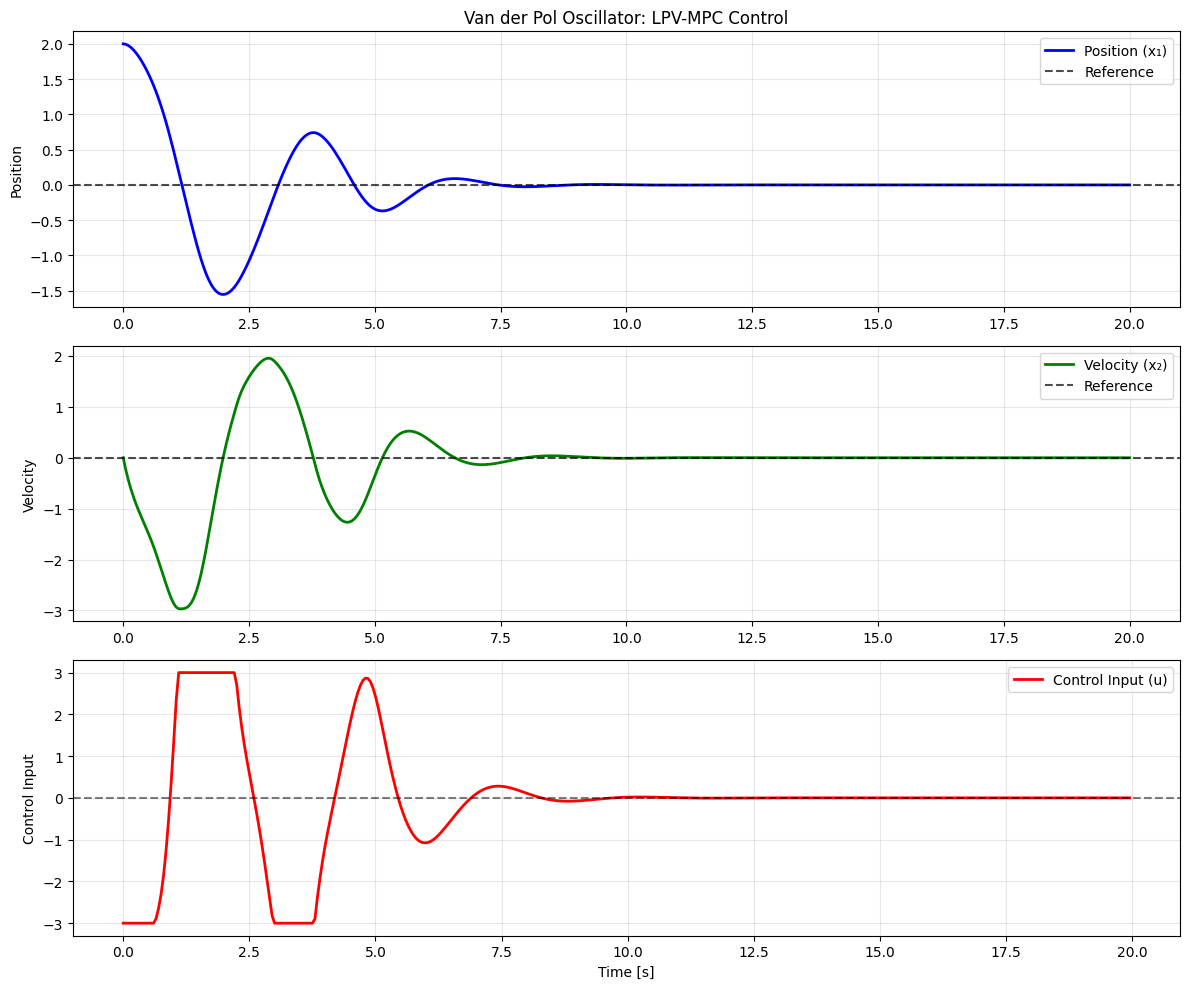

Computing reference limit cycle...


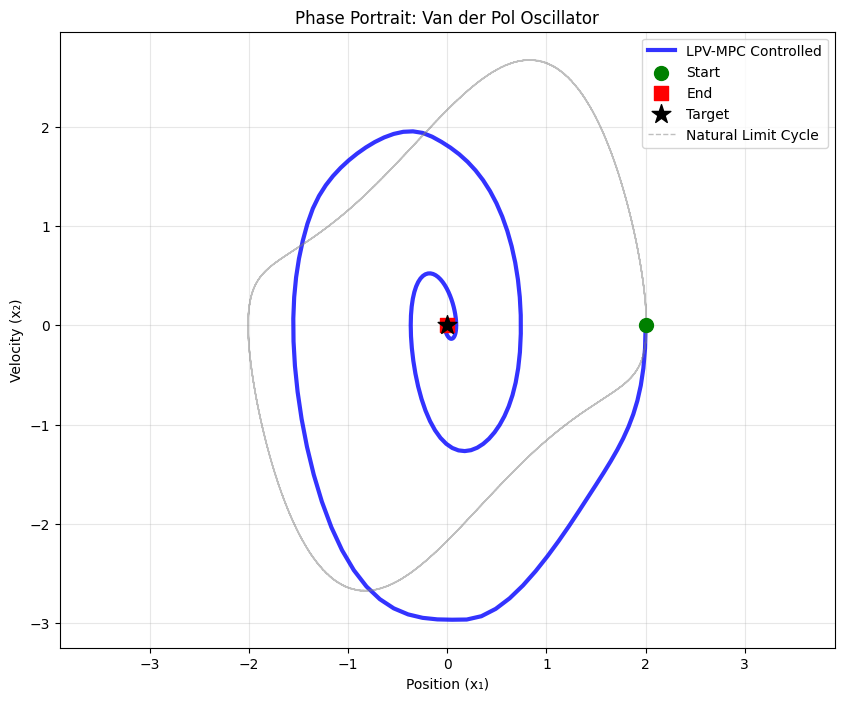

Analyzing learned scheduler...


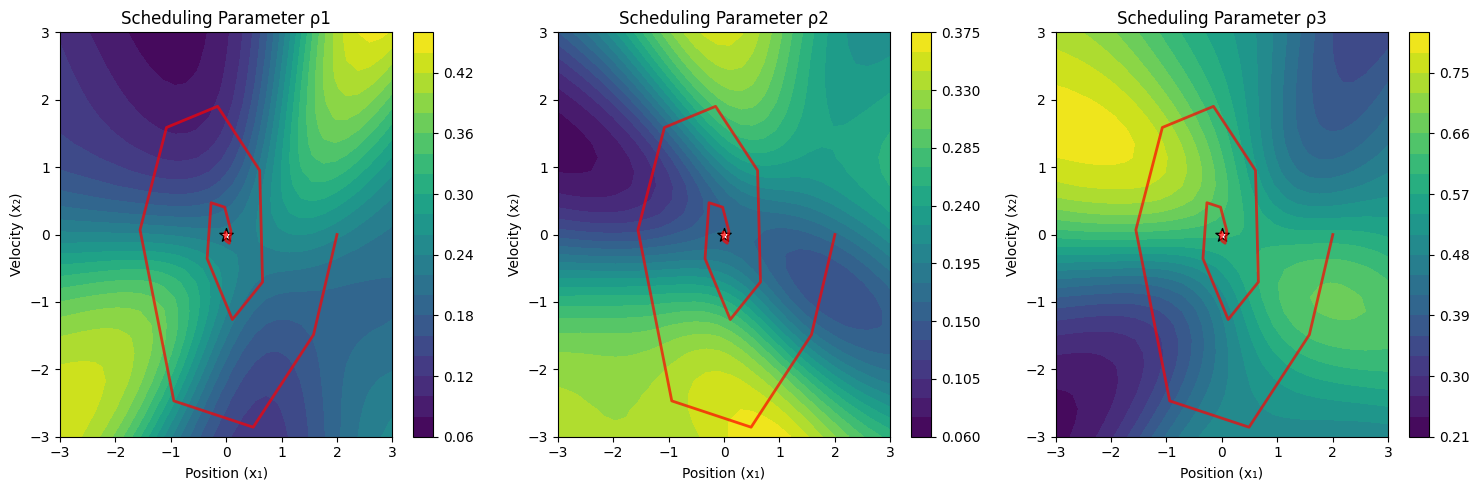

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Simple LPV-PINN-MPC demonstration: Van der Pol Oscillator
---------------------------------------------------------
Perfect test system for LPV learning:
- 2 states: [position, velocity]
- 1 input: forcing term
- Nonlinear dynamics with different regimes (linear near origin, nonlinear far out)
- Well-known reference behavior
- Easy to visualize and understand

Van der Pol equation: ẍ - μ(1-x²)ẋ + x = u
State form: dx₁/dt = x₂, dx₂/dt = μ(1-x₁²)x₂ - x₁ + u
"""
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

def set_seed(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)

# ------------------------------ Van der Pol System ------------------------------

class VanDerPolParams:
    """Van der Pol oscillator parameters"""
    def __init__(self, mu=1.0, u_max=5.0):
        self.mu = mu          # Nonlinearity parameter
        self.u_max = u_max    # Input constraint
        self.u_min = -u_max

def vanderpol_rhs(x: np.ndarray, u: np.ndarray, P: VanDerPolParams) -> np.ndarray:
    """
    Van der Pol dynamics: ẍ - μ(1-x²)ẋ + x = u
    States: x = [position, velocity]
    Input: u = forcing term
    """
    x = np.asarray(x, dtype=np.float64)
    u = np.asarray(u, dtype=np.float64)
    
    x1, x2 = x[..., 0], x[..., 1]  # position, velocity
    
    # Handle scalar input properly
    if u.ndim == 0:  # scalar
        u_scalar = u
    elif u.shape == ():  # 0-dimensional array
        u_scalar = u.item()
    elif u.ndim == 1 and len(u) == 1:  # 1D array with single element
        u_scalar = u[0]
    else:  # assume first element
        u_scalar = u.flat[0]
    
    dx1 = x2
    dx2 = P.mu * (1 - x1**2) * x2 - x1 + u_scalar
    
    return np.stack([dx1, dx2], axis=-1)

def rk4_step(x: np.ndarray, u: np.ndarray, dt: float, P: VanDerPolParams) -> np.ndarray:
    """RK4 integration step"""
    k1 = vanderpol_rhs(x, u, P)
    k2 = vanderpol_rhs(x + 0.5*dt*k1, u, P)
    k3 = vanderpol_rhs(x + 0.5*dt*k2, u, P)
    k4 = vanderpol_rhs(x + dt*k3, u, P)
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# ------------------------------ Data Generation ------------------------------

def generate_rich_data(num_traj=30, T=200, dt=0.05, P=VanDerPolParams(), noise_std=0.01):
    """Generate training data with diverse trajectories"""
    Xs, Us, Xps = [], [], []
    
    print(f"Generating {num_traj} trajectories...")
    
    for traj in range(num_traj):
        if traj % 10 == 0:
            print(f"  Trajectory {traj}/{num_traj}")
        
        # Diverse initial conditions
        if traj < num_traj // 3:
            # Near origin (linear regime)
            x = np.random.uniform(-0.5, 0.5, size=2)
        elif traj < 2 * num_traj // 3:
            # Medium amplitude (transitional regime)
            x = np.random.uniform(-2.0, 2.0, size=2)
        else:
            # Large amplitude (strong nonlinear regime)
            x = np.random.uniform(-3.0, 3.0, size=2)
        
        # Generate input sequence with different characteristics
        if traj < num_traj // 3:
            # High frequency excitation
            u_seq = generate_input_sequence(T, P, mode='high_freq')
        elif traj < 2 * num_traj // 3:
            # Steps and ramps
            u_seq = generate_input_sequence(T, P, mode='steps')
        else:
            # Smooth sinusoidal + noise
            u_seq = generate_input_sequence(T, P, mode='smooth')
        
        for t in range(T):
            u = float(u_seq[t])  # Ensure scalar
            x_next = rk4_step(x, u, dt, P)
            
            # Add measurement noise
            if noise_std > 0:
                x_meas = x + np.random.normal(scale=noise_std, size=x.shape)
                x_next_meas = x_next + np.random.normal(scale=noise_std, size=x_next.shape)
            else:
                x_meas, x_next_meas = x, x_next
            
            Xs.append(x_meas.copy())
            Us.append(np.array([u]))  # Store as 1D array for consistency
            Xps.append(x_next_meas.copy())
            x = x_next
    
    return np.array(Xs), np.array(Us), np.array(Xps)

def generate_input_sequence(T: int, P: VanDerPolParams, mode: str = 'mixed'):
    """Generate diverse input sequences"""
    t = np.arange(T) * 0.05  # Assuming dt=0.05
    
    if mode == 'high_freq':
        # High frequency switching
        u = np.random.choice([-P.u_max, 0, P.u_max], size=T)
        # Smooth it slightly
        for i in range(1, T):
            if np.random.rand() < 0.7:  # 70% chance to keep previous value
                u[i] = u[i-1]
    
    elif mode == 'steps':
        # Step inputs
        u = np.zeros(T)
        step_length = max(1, T // 5)
        for i in range(0, T, step_length):
            end_idx = min(i + step_length, T)
            u[i:end_idx] = np.random.uniform(P.u_min, P.u_max)
    
    elif mode == 'smooth':
        # Smooth sinusoidal with multiple frequencies
        u = (0.8 * np.sin(0.5 * t) + 
             0.4 * np.sin(2.0 * t) + 
             0.2 * np.random.randn(T))
        u = np.clip(u, P.u_min, P.u_max)
    
    else:  # mixed
        # Combination
        u = np.zeros(T)
        third = max(1, T // 3)
        u[:third] = generate_input_sequence(third, P, 'steps')[:third]
        if third < T:
            remaining = T - third
            second_third = min(third, remaining)
            u[third:third+second_third] = generate_input_sequence(second_third, P, 'smooth')[:second_third]
            if third + second_third < T:
                final_part = T - third - second_third
                u[third+second_third:] = generate_input_sequence(final_part, P, 'high_freq')[:final_part]
    
    return u

class SeqDataset(Dataset):
    """Simple sequence dataset"""
    def __init__(self, X, U, Xp, seq_len=10):
        self.X = torch.as_tensor(X, dtype=torch.float32)
        self.U = torch.as_tensor(U, dtype=torch.float32)
        self.Xp = torch.as_tensor(Xp, dtype=torch.float32)
        self.seq_len = seq_len
        
        # Create sequence indices
        self.indices = list(range(0, len(X) - seq_len, seq_len//2))
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        start = self.indices[idx]
        end = start + self.seq_len
        return self.X[start:end], self.U[start:end], self.Xp[start:end]

# ------------------------------ Simple LPV Model ------------------------------

class SimpleScheduler(nn.Module):
    """Compact scheduler network"""
    def __init__(self, nx=2, p=3, nh=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nx, nh), nn.Tanh(),
            nn.Linear(nh, nh), nn.Tanh(),
            nn.Linear(nh, p)
        )
    
    def forward(self, x):
        logits = self.net(x)
        return torch.softmax(logits, dim=-1)  # Simplex constraint

class SimpleLPVHead(nn.Module):
    """Simple LPV system matrices"""
    def __init__(self, nx=2, nu=1, p=3):
        super().__init__()
        # Base matrices
        self.A0 = nn.Parameter(torch.eye(nx))
        self.B0 = nn.Parameter(torch.randn(nx, nu) * 0.1)
        
        # Parameter-varying components
        self.Ai = nn.Parameter(torch.randn(p, nx, nx) * 0.1)
        self.Bi = nn.Parameter(torch.randn(p, nx, nu) * 0.1)
    
    def AB(self, rho):
        """Compute A(ρ), B(ρ)"""
        A = self.A0.unsqueeze(0) + torch.einsum('bp,pij->bij', rho, self.Ai)
        B = self.B0.unsqueeze(0) + torch.einsum('bp,pij->bij', rho, self.Bi)
        return A, B

class SimpleLPVModel(nn.Module):
    """Simple LPV model for Van der Pol"""
    def __init__(self, nx=2, nu=1, p=3):
        super().__init__()
        self.sched = SimpleScheduler(nx, p)
        self.head = SimpleLPVHead(nx, nu, p)
    
    @staticmethod
    def physics_rhs_torch(x, u, mu=1.0):
        """Van der Pol physics in PyTorch"""
        x1, x2 = x[..., 0], x[..., 1]
        u_val = u[..., 0] if u.shape[-1] > 0 else u
        
        dx1 = x2
        dx2 = mu * (1 - x1**2) * x2 - x1 + u_val
        
        return torch.stack([dx1, dx2], dim=-1)
    
    def step(self, x, u):
        """One step: x_{k+1} = A(ρ) x_k + B(ρ) u_k"""
        rho = self.sched(x)
        A, B = self.head.AB(rho)
        
        x_next = torch.einsum('bij,bj->bi', A, x) + torch.einsum('bij,bj->bi', B, u)
        return x_next, rho, (A, B)

def simple_loss(model, Xs, Us, Xps, P: VanDerPolParams, dt=0.05):
    """Simple but effective loss function"""
    B, T, nx = Xs.shape
    
    # 1. One-step prediction accuracy (MOST IMPORTANT)
    X_flat = Xs.reshape(-1, nx)
    U_flat = Us.reshape(-1, Us.shape[-1])
    Xp_flat = Xps.reshape(-1, nx)
    
    x1_pred, _, _ = model.step(X_flat, U_flat)
    L_pred = torch.mean((x1_pred - Xp_flat)**2)
    
    # 2. Physics consistency (PINN component)
    n_phys = min(B, 16)  # Sample for efficiency
    idx = torch.randperm(B)[:n_phys]
    x_phys = Xs[idx, 0, :]
    u_phys = Us[idx, 0, :]
    
    # True physics step
    x_true_phys = x_phys + dt * model.physics_rhs_torch(x_phys, u_phys, P.mu)
    # Predicted step
    x_pred_phys, _, _ = model.step(x_phys, u_phys)
    
    L_phys = torch.mean((x_pred_phys - x_true_phys)**2)
    
    # 3. Multi-step consistency (short horizon)
    x_rollout = Xs[:, 0, :]
    L_rollout = 0.0
    steps = min(3, T-1)
    for k in range(steps):
        u_k = Us[:, k, :]
        x_rollout, _, _ = model.step(x_rollout, u_k)
        L_rollout += torch.mean((x_rollout - Xps[:, k, :])**2)
    L_rollout /= steps
    
    # 4. Regularization
    L_reg = (model.head.Ai**2).mean() + (model.head.Bi**2).mean()
    
    # Weighted combination - prioritize prediction accuracy
    total_loss = (10.0 * L_pred +    # Highest priority
                  2.0 * L_phys +     # Physics consistency  
                  1.0 * L_rollout +  # Multi-step
                  0.01 * L_reg)      # Regularization
    
    return total_loss, {
        'pred': L_pred.item(),
        'phys': L_phys.item(), 
        'rollout': L_rollout.item(),
        'reg': L_reg.item()
    }

# ------------------------------ Simple MPC ------------------------------

def solve_dare_simple(A, B, Q, R, max_iter=100, tol=1e-8):
    """Simple DARE solver"""
    P = Q.copy()
    
    for i in range(max_iter):
        try:
            # Solve for feedback gain
            S = R + B.T @ P @ B
            K = np.linalg.solve(S, B.T @ P @ A)
            
            # Update P
            P_new = Q + A.T @ P @ (A - B @ K)
            
            # Check convergence
            if np.linalg.norm(P_new - P) < tol:
                return P_new, K
            
            P = P_new
            
        except np.linalg.LinAlgError:
            # Add regularization if singular
            S = R + B.T @ P @ B + 1e-6 * np.eye(B.shape[1])
            K = np.linalg.solve(S, B.T @ P @ A)
            P = Q + A.T @ P @ (A - B @ K)
    
    return P, K

def simple_lpv_mpc(model, x_current, x_ref, Q, R, P_sys, N=15):
    """Simple LPV-based MPC controller"""
    device = next(model.parameters()).device
    
    # Get current linearization
    x_torch = torch.as_tensor(x_current[None, :], dtype=torch.float32, device=device)
    
    with torch.no_grad():
        rho = model.sched(x_torch)
        A, B = model.head.AB(rho)
        A_np = A[0].cpu().numpy()
        B_np = B[0].cpu().numpy()
    
    # Solve LQR for current linearization
    try:
        P_lqr, K = solve_dare_simple(A_np, B_np, Q, R)
        u = -K @ (x_current - x_ref)
    except:
        u = np.array([0.0])  # Safe fallback
    
    # Apply constraints
    return np.clip(u, P_sys.u_min, P_sys.u_max)

# ------------------------------ Main Function ------------------------------

def main():
    set_seed(42)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)
    
    # System parameters
    P = VanDerPolParams(mu=1.0, u_max=3.0)
    dt = 0.05  # 50ms sampling
    
    print("=== Simple LPV-PINN-MPC: Van der Pol Oscillator ===")
    print(f"Nonlinearity parameter μ = {P.mu}")
    print(f"Input constraints: [{P.u_min}, {P.u_max}]")
    print(f"Sampling time: {dt} seconds")
    
    # Generate data
    print("\nGenerating training data...")
    X, U, Xp = generate_rich_data(num_traj=40, T=150, dt=dt, P=P, noise_std=0.005)
    
    print(f"Dataset: {X.shape[0]} transitions")
    print(f"State range: x1 ∈ [{X[:, 0].min():.2f}, {X[:, 0].max():.2f}], "
          f"x2 ∈ [{X[:, 1].min():.2f}, {X[:, 1].max():.2f}]")
    
    # Split data
    n = X.shape[0]
    idx = np.random.permutation(n)
    n_tr = int(0.8 * n)
    
    Xtr, Utr, Xptr = X[idx[:n_tr]], U[idx[:n_tr]], Xp[idx[:n_tr]]
    Xva, Uva, Xpva = X[idx[n_tr:]], U[idx[n_tr:]], Xp[idx[n_tr:]]
    
    # Create datasets  
    train_ds = SeqDataset(Xtr, Utr, Xptr, seq_len=8)
    valid_ds = SeqDataset(Xva, Uva, Xpva, seq_len=8)
    train_ld = DataLoader(train_ds, batch_size=64, shuffle=True)
    valid_ld = DataLoader(valid_ds, batch_size=64, shuffle=False)
    
    print(f"Training batches: {len(train_ld)}, Validation batches: {len(valid_ld)}")
    
    # Create model
    model = SimpleLPVModel(nx=2, nu=1, p=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Training
    print("\nTraining LPV model...")
    best_val = float('inf')
    
    for ep in range(1, 21):
        model.train()
        tr_loss = 0.0
        tr_metrics = {'pred': 0, 'phys': 0, 'rollout': 0, 'reg': 0}
        
        for Xs, Us, Xps in train_ld:
            Xs, Us, Xps = Xs.to(device), Us.to(device), Xps.to(device)
            
            loss, metrics = simple_loss(model, Xs, Us, Xps, P, dt)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            tr_loss += loss.item()
            for k, v in metrics.items():
                tr_metrics[k] += v
        
        tr_loss /= len(train_ld)
        for k in tr_metrics:
            tr_metrics[k] /= len(train_ld)
        
        # Validation
        model.eval()
        with torch.no_grad():
            va_loss = 0.0
            for Xs, Us, Xps in valid_ld:
                Xs, Us, Xps = Xs.to(device), Us.to(device), Xps.to(device)
                loss, _ = simple_loss(model, Xs, Us, Xps, P, dt)
                va_loss += loss.item()
            va_loss /= len(valid_ld)
        
        print(f"Epoch {ep:02d} | Train {tr_loss:.4f} | Valid {va_loss:.4f} | "
              f"Pred {tr_metrics['pred']:.5f} | Phys {tr_metrics['phys']:.5f}")
        
        if va_loss < best_val:
            best_val = va_loss
            torch.save(model.state_dict(), "simple_lpv_best.pt")
    
    print(f"Best validation loss: {best_val:.4f}")
    
    # Load best model
    model.load_state_dict(torch.load("simple_lpv_best.pt", map_location=device))
    model.eval()
    
    # Evaluate accuracy
    print("\n=== Model Evaluation ===")
    with torch.no_grad():
        Xva_t = torch.as_tensor(Xva, dtype=torch.float32, device=device)
        Uva_t = torch.as_tensor(Uva, dtype=torch.float32, device=device)
        Xpva_t = torch.as_tensor(Xpva, dtype=torch.float32, device=device)
        
        Xp_pred, _, _ = model.step(Xva_t, Uva_t)
        rmse = torch.sqrt(torch.mean((Xp_pred - Xpva_t)**2)).item()
        
        rmse_x1 = torch.sqrt(torch.mean((Xp_pred[:, 0] - Xpva_t[:, 0])**2)).item()
        rmse_x2 = torch.sqrt(torch.mean((Xp_pred[:, 1] - Xpva_t[:, 1])**2)).item()
        
        print(f"Overall RMSE: {rmse:.5f}")
        print(f"Position (x1) RMSE: {rmse_x1:.5f}")
        print(f"Velocity (x2) RMSE: {rmse_x2:.5f}")
    
    # ==================== MPC CONTROL TEST ====================
    print("\n=== LPV-MPC Control Test ===")
    
    # Control setup - regulate to origin with smooth approach
    x_ref = np.array([0.0, 0.0])       # Regulate to origin
    Q = np.diag([10.0, 1.0])           # Penalize position more than velocity
    R = np.array([[0.1]])              # Input penalty
    
    # Simulation
    Tsim = 400  # 20 seconds
    x0 = np.array([2.0, 0.0])  # Start from displaced position
    
    print(f"Reference: x1={x_ref[0]}, x2={x_ref[1]}")
    print(f"Initial: x1={x0[0]}, x2={x0[1]}")
    
    # Simulate closed-loop control
    print("Simulating closed-loop control...")
    xs = [x0.copy()]
    us = []
    x = x0.copy()
    
    for t in range(Tsim):
        # Compute control using learned LPV model
        u = simple_lpv_mpc(model, x, x_ref, Q, R, P, N=20)
        print(f"Time {t*dt:.2f}s | State: x1={x[0]:.4f}, x2={x[1]:.4f} | Control: u={u[0]:.4f}")
        us.append(u.copy())
        
        # Apply to true system
        x = rk4_step(x, u[0], dt, P)
        xs.append(x.copy())
    
    xs = np.array(xs)
    us = np.array(us)
    
    # Performance metrics
    steady_idx = 200  # After 10 seconds
    final_error = np.abs(xs[-1, :] - x_ref)
    steady_error = np.mean(np.abs(xs[steady_idx:, :] - x_ref), axis=0)
    control_effort = np.sum(us**2) * dt
    
    print(f"Final error: x1={final_error[0]:.4f}, x2={final_error[1]:.4f}")
    print(f"Steady-state error: x1={steady_error[0]:.4f}, x2={steady_error[1]:.4f}")
    print(f"Control effort: {control_effort:.2f}")
    
    # ==================== VISUALIZATION ====================
    print("\n=== Generating Plots ===")
    
    # Time series plot
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    tt = np.arange(len(xs)) * dt
    
    # States
    axes[0].plot(tt, xs[:, 0], 'b-', label='Position (x₁)', linewidth=2)
    axes[0].axhline(x_ref[0], color='black', linestyle='--', alpha=0.7, label='Reference')
    axes[0].set_ylabel('Position')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    axes[0].set_title('Van der Pol Oscillator: LPV-MPC Control')
    
    axes[1].plot(tt, xs[:, 1], 'g-', label='Velocity (x₂)', linewidth=2)  
    axes[1].axhline(x_ref[1], color='black', linestyle='--', alpha=0.7, label='Reference')
    axes[1].set_ylabel('Velocity')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    # Control input
    axes[2].plot(tt[:-1], us[:, 0], 'r-', label='Control Input (u)', linewidth=2)
    axes[2].axhline(0, color='black', linestyle='--', alpha=0.5)
    axes[2].set_ylabel('Control Input')
    axes[2].set_xlabel('Time [s]')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    plt.tight_layout()
    plt.savefig('vanderpol_lpv_control.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Phase portrait
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Controlled trajectory
    ax.plot(xs[:, 0], xs[:, 1], 'b-', linewidth=3, label='LPV-MPC Controlled', alpha=0.8)
    ax.scatter(xs[0, 0], xs[0, 1], color='green', s=100, marker='o', label='Start', zorder=5)
    ax.scatter(xs[-1, 0], xs[-1, 1], color='red', s=100, marker='s', label='End', zorder=5)
    ax.scatter(x_ref[0], x_ref[1], color='black', s=200, marker='*', label='Target', zorder=10)
    
    # Uncontrolled limit cycle (for reference)
    print("Computing reference limit cycle...")
    x_free = np.array([2.0, 0.0])
    xs_free = [x_free.copy()]
    for t in range(1000):
        x_free = rk4_step(x_free, 0.0, dt, P)  # No control input
        xs_free.append(x_free.copy())
    xs_free = np.array(xs_free)
    ax.plot(xs_free[200:, 0], xs_free[200:, 1], 'gray', alpha=0.5, linewidth=1, 
            linestyle='--', label='Natural Limit Cycle')
    
    ax.set_xlabel('Position (x₁)')
    ax.set_ylabel('Velocity (x₂)')
    ax.set_title('Phase Portrait: Van der Pol Oscillator')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.axis('equal')
    
    plt.savefig('vanderpol_phase_portrait.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Scheduler visualization
    print("Analyzing learned scheduler...")
    x1_range = np.linspace(-3, 3, 30)
    x2_range = np.linspace(-3, 3, 30)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    
    test_states = np.column_stack([X1.ravel(), X2.ravel()])
    test_states_t = torch.as_tensor(test_states, dtype=torch.float32, device=device)
    
    with torch.no_grad():
        rhos = model.sched(test_states_t).cpu().numpy()
    
    # Plot scheduler parameters
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        rho_grid = rhos[:, i].reshape(X1.shape)
        im = axes[i].contourf(X1, X2, rho_grid, levels=20, cmap='viridis')
        axes[i].set_xlabel('Position (x₁)')
        axes[i].set_ylabel('Velocity (x₂)')
        axes[i].set_title(f'Scheduling Parameter ρ{i+1}')
        plt.colorbar(im, ax=axes[i])
        
        # Overlay controlled trajectory
        axes[i].plot(xs[::10, 0], xs[::10, 1], 'r-', alpha=0.7, linewidth=2)
        axes[i].scatter(x_ref[0], x_ref[1], color='white', s=100, marker='*', edgecolors='black')
    
    plt.tight_layout()
    plt.savefig('vanderpol_scheduler.png', dpi=150, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()